In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd

In [2]:
%matplotlib inline
%load_ext tensorboard

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
CSV_FILE_PATH = "data/esc50.csv"  # path of csv file
DATA_PATH = "data/audio/44100/" # path to folder containing audio files

In [4]:
#reading the csv file
df = pd.read_csv(CSV_FILE_PATH)
df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [5]:
class_selection = [
    "thunderstorm",
    "rain",
    "sea_weaves",
    "dog",
    "cat",
    "chirping_birds",    
    "breathing",
    "keyboard_typing",
    "coughing",
    "drinking_sipping",
    "car_horn"
]

In [6]:
df_sel = df[df["category"].isin(class_selection)]
classes = df_sel['category'].unique()

In [7]:
class_dict = {i:x for x,i in enumerate(classes)}
class_dict

{'dog': 0,
 'chirping_birds': 1,
 'thunderstorm': 2,
 'keyboard_typing': 3,
 'car_horn': 4,
 'drinking_sipping': 5,
 'rain': 6,
 'breathing': 7,
 'coughing': 8,
 'cat': 9}

In [8]:
df_sel.loc[:, 'target'] = df_sel['category'].map(class_dict)


In [9]:
# select a sample 
sample_df = df_sel.drop_duplicates(subset=['target'])
sample_df

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,1,chirping_birds,False,100038,A
4,1-101296-A-19.wav,1,2,thunderstorm,False,101296,A
36,1-137-A-32.wav,1,3,keyboard_typing,False,137,A
53,1-17124-A-43.wav,1,4,car_horn,False,17124,A
61,1-17295-A-29.wav,1,5,drinking_sipping,False,17295,A
62,1-17367-A-10.wav,1,6,rain,True,17367,A
76,1-18631-A-23.wav,1,7,breathing,False,18631,A
84,1-19111-A-24.wav,1,8,coughing,False,19111,A
175,1-34094-A-5.wav,1,9,cat,False,34094,A


In [10]:
# computing mel spectrograms

signals = {}
mel_spectrograms = {}
mfccs = {}

for i, row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(DATA_PATH+ row["filename"])
    signals[row["category"]] = signal    # fill signal for each category. eg. signal["dog"] = signal of dog sound
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row["category"]] = mel_spec
    
    mfcc = librosa.feature.mfcc(y=signal , sr=rate , n_mfcc=13, dct_type=3)
    mfccs[row["category"]] = mfcc

10it [00:04,  2.14it/s]


In [11]:
sample_df.iloc[0]["filename"]

'1-100032-A-0.wav'

In [12]:
# Reproduce some audio samples
print(sample_df.iloc[0]["category"])
ipd.Audio(DATA_PATH + sample_df.iloc[0]["filename"])
print(sample_df.iloc[1]["category"])
ipd.Audio(DATA_PATH + sample_df.iloc[1]["filename"])
print(sample_df.iloc[2]["category"])
ipd.Audio(DATA_PATH + sample_df.iloc[2]["filename"])

dog


chirping_birds


thunderstorm


In [13]:
import seaborn as sns

def plot_signal_seaborn(signal):
    """
    this function will take the signal dictionary and plot the signals using seaborn
    """
    sns.set(style='whitegrid')
    fig , axes = plt.subplots(nrows=2 , ncols=5 , sharex =False ,sharey=True,figsize=(20,5))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            sns.lineplot(data=list(signals.values())[i], ax=axes[x,y])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

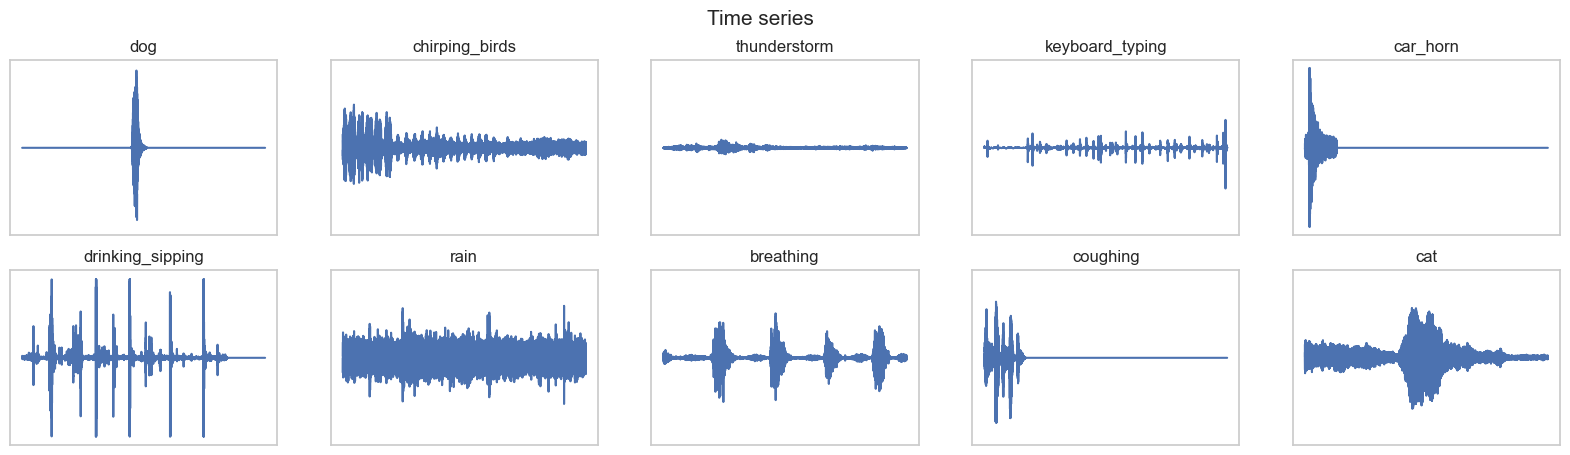

In [14]:
plot_signal_seaborn(signals)

In [15]:
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=2 , ncols=5 , sharex=False, sharey=True , figsize=(40,10))
    fig.suptitle('mel')
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            # axes[x,y].get_xaxis().set_visible(False)
            # axes[x,y].get_yaxis().set_visible(False)
            i+=1

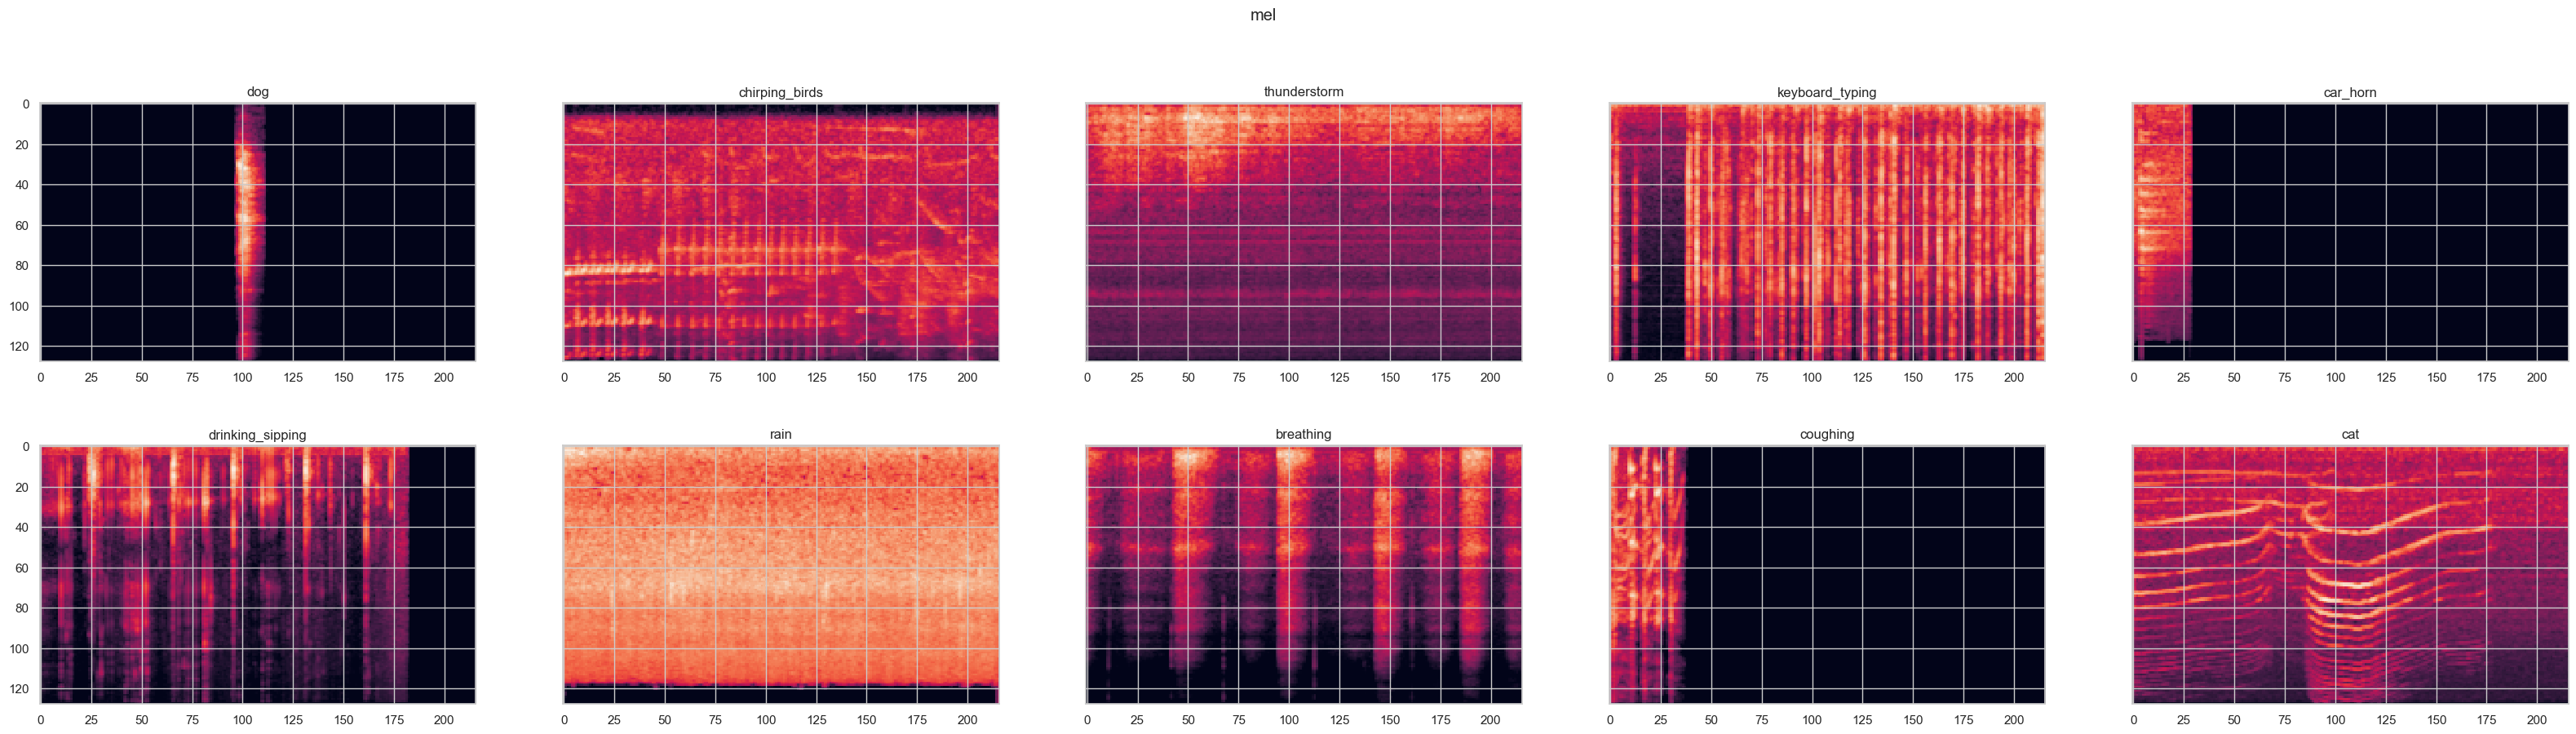

In [16]:
dis_feature(mel_spectrograms)

In [44]:
# for each audio sample, create three additional random samples to augment data
# each audio sampel has typically 5 seconds. 

# TODO: experiment with different lengths of the random samples or no random samples at all and see the performance. 

X , y = [] , []
for data in tqdm(df_sel.iterrows()):
  sig , sr = librosa.load(DATA_PATH+data[1][0])
  for i in range(3):
    n = np.random.randint(0, len(sig)-(sr*2)) # chose a random number between 0 and about 3/5 of the signal length or 3 seconds as signals are 5 seconds long.
    sig_ = sig[n : int(n+(sr*2))] # take a 2 seconds long chunk of the signal starting from the n random position. 
    mfcc_ = librosa.feature.mfcc(y=sig_ , sr=sr, n_mfcc=13)
    X.append(mfcc_)
    y.append(data[1][1])

# convert list to numpy array
X = np.array(X) 
y = np.array(y)

#one-hot encoding the target
y = tf.keras.utils.to_categorical(y , num_classes=10)

# our tensorflow model takes input as (no_of_sample , height , width , channel).
# here X has dimension (no_of_sample , height , width).
# So, the below code will reshape it to (no_of_sample , height , width , 1).
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

0it [00:00, ?it/s]/var/folders/rz/hqy45d3569g71gtmcbpt6vkr0000gp/T/ipykernel_2011/2562323556.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sig , sr = librosa.load(DATA_PATH+data[1][0])
/var/folders/rz/hqy45d3569g71gtmcbpt6vkr0000gp/T/ipykernel_2011/2562323556.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[1][1])
400it [00:07, 54.01it/s]


In [19]:
X.shape
y.shape

(1200, 13, 87, 1)

(1200, 10)

In [45]:
x_train , x_val , y_train , y_val = train_test_split(X , y ,test_size=0.2, random_state=2023)

In [46]:
# Modeling

INPUTSHAPE = (13,87,1)

In [22]:
#TODO: learn about different CNN patterns and how to tune parameters to obtain the best model. 


model =  models.Sequential([
                          layers.Conv2D(16 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          layers.Conv2D(16, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.GlobalAveragePooling2D(),


                          layers.Dense(32 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')

2023-12-22 20:50:23.533407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-22 20:50:23.533568: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 85, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 83, 16)         2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 81, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 79, 32)         9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 77, 64)         18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 75, 32)         18464     
                                                                 
 global_average_pooling2d (G  (None, 32)               0

In [24]:
LOGDIR = "logs"
CPKT = "cpkt/"

In [25]:
#this callback is used to prevent overfitting.
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#this checkpoint saves the best weights of model at every epoch
callback_2 = tf.keras.callbacks.ModelCheckpoint(
    CPKT, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None
)

#this is for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGDIR)

In [26]:
history = model.fit(x_train,y_train ,
            validation_data=(x_val,y_val),
            epochs=500,
            callbacks = [callback_1 , callback_2 , tensorboard_callback])

Epoch 1/500


2023-12-22 20:50:23.861182: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-22 20:50:24.110937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 19ms/step - loss: 2.0507 - acc: 0.2198 - val_loss: 1.8579 - val_acc: 0.2333
Epoch 2/500
 1/30 [>.............................] - ETA: 0s - loss: 1.7257 - acc: 0.2500

2023-12-22 20:50:24.803958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 14ms/step - loss: 1.6894 - acc: 0.2115 - val_loss: 1.6309 - val_acc: 0.2667
Epoch 3/500
30/30 [==============================] - 0s 13ms/step - loss: 1.5895 - acc: 0.2719 - val_loss: 1.6833 - val_acc: 0.2458
Epoch 4/500
30/30 [==============================] - 0s 14ms/step - loss: 1.5468 - acc: 0.3031 - val_loss: 1.5899 - val_acc: 0.3458
Epoch 5/500
30/30 [==============================] - 0s 13ms/step - loss: 1.4889 - acc: 0.3500 - val_loss: 1.6142 - val_acc: 0.2833
Epoch 6/500
30/30 [==============================] - 0s 13ms/step - loss: 1.4537 - acc: 0.3833 - val_loss: 1.5181 - val_acc: 0.3500
Epoch 7/500
30/30 [==============================] - 0s 13ms/step - loss: 1.4145 - acc: 0.4021 - val_loss: 1.5265 - val_acc: 0.3292
Epoch 8/500
30/30 [==============================] - 0s 13ms/step - loss: 1.3447 - acc: 0.4354 - val_loss: 1.5774 - val_acc: 0.3000
Epoch 9/500
30/30 [==============================] - 0s 14ms/step - loss: 1.2521 - acc: 